In [1]:
library(DEqMS)
library(patchwork)
library(tidyverse)

source("../../evaluation_utils/evaluation/DE_analysis.R")
source("../../evaluation_utils/plots/DE_plots.R")
source("../../evaluation_utils/plots/eda_plots.R")
source("../../evaluation_utils/filtering/filtering_normalization.R")

library(jsonlite)

Loading required package: ggplot2

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Loading required package: matrixStats

Warning message:
“package ‘matrixStats’ was built under R version 4.2.3”
Loading required package: limma

Warning message:
“package ‘tidyverse’ was built under R version 4.2.2”
Warning message:
“package ‘tibble’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.2”
Warning message:
“package ‘readr’ was built under R version 4.2.2”
Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘forcats’ was built under R version 4.2.2”
Warning message:
“package ‘lubridate’ was built under R version 4.2.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.

In [2]:
create_plots <- function(pg_matrix, metadata, name, plot_file_prefix, shape_col="Pool", width=14, log_transform=FALSE){

    # if not log transformed, log transform
    if (!log_transform){
        pg_matrix <- log2(pg_matrix + 1)
    }

    # plots
    plot_pca <- pca_plot(pg_matrix, metadata, 
        title=paste0(name, " PCA"), 
        quantitative_col_name='file', col_col='condition', shape_col=shape_col)
    plot_boxplot <- boxplot_pg(pg_matrix, metadata, 
        title=paste0(name, " Boxplot"), 
        color_col='condition', quantitativeColumnName='file')
    plot_density <- plotIntensityDensityByPool(pg_matrix, metadata, 
        title=paste0(name, " Density"), 
        poolColumnName='condition', 
        quantitativeColumnName='file')
    plot_heatmap <- heatmap_plot(pg_matrix, metadata, name, lab=shape_col)

    layout <- (plot_density | plot_pca) /
            (plot_boxplot | plot_heatmap)
    # save plot
    ggsave(file = paste0(plot_file_prefix, "_plots.svg"), plot = layout, width = width, height = 10)
}


# Separate run for meta

In [3]:
filter_list_META = list("01_smaller_lib_balanced_PG_MajorPG" = list(), "01_smaller_lib_imbalanced_PG_MajorPG" = list(), 
        "01_smaller_lib_downsampled_PG_MajorPG" = list()
)

analyzed_proteins <- list()

In [4]:
options(warn=-1)
datasets_list = c('01_smaller_lib_balanced_PG_MajorPG', "01_smaller_lib_imbalanced_PG_MajorPG", "01_smaller_lib_downsampled_PG_MajorPG")
labs_list = c('Center1', 'Center2', 'Center3')


for(dataset in datasets_list){
  plots_list = list()
  plots_list_named = list()
  cat('\n\nDataset: ', dataset, "\n")
  
  for (name in labs_list) {
    path_to_reports = paste0('/home/yuliya/repos/cosybio/FedProt/data/TMT_data/', dataset, '/', name, "/")
    output_path = paste0('/home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/Meta_DE/', dataset, '/')
    
    if(!dir.exists(output_path)){
      dir.create(output_path, recursive = TRUE)
    }
    cat('\nLab: ', name, "\n")

    batch_info <- read.csv(paste0(path_to_reports, "metadata.tsv"), sep = "\t") %>%
      filter(Group != "Common Reference") %>%
      mutate(
          file = Quantitative.column.name,
          lab = as.factor(Center),
          condition = factor(Group, levels = c('heathy', 'FSGS')),
          Pool = as.factor(Pool)
      )
    intensities <- read.csv(paste0(path_to_reports, "pg_intensities.tsv"), row.names=1, sep = "\t")
    intensities <- intensities[, batch_info$file]

    counts = read_tsv(paste0(path_to_reports, "/pg_counts.tsv"), show_col_types = FALSE)
    counts <- counts %>% column_to_rownames('Majority.protein.IDs') %>%
      rename(count = 'counts')
    
    intensities <- filter_na_proteins(intensities, batch_info, "file")
    intensities <- filter_by_condition(intensities, batch_info,
      'file', c('heathy', 'FSGS'), 'condition') 
    intensities <- filter_per_center(intensities, batch_info, "file",
      unique(batch_info$Pool), 'Pool', min_number = 1)

    #########################################################
    # Filter - remove proteins with 1 count 
    intensities <- intensities[rownames(intensities) %in% rownames(filter(counts, count > 1)), ]
    cat("Rows after filtering 1 count:", nrow(intensities), "\n")

    filter_list_META[[dataset]][[name]] <- rownames(intensities)

    # filters (to analyze the same proteins)
    # intensities <- intensities[analyzed_proteins[[dataset]],]
    cat("Rows after all filters:", nrow(intensities), "\n")
    cat("Samples: ", ncol(intensities), "\n")

    # Normalization
    # median normalization
    intensities <- intensities[, batch_info$file]
    intensities <- medianNorm(intensities) %>% as.data.frame()

    cat("IRS normalization for center: ", name, "\n")
    irs_results <- irsNorm_in_silico_single_center(intensities, batch_info,
      pool_col = "Pool",
      column_name = "file",
      center = name,
      aggregation_method = "average",
      add_refs = FALSE
    )
    intensities <- irs_results$corrected_data %>% as.data.frame()
    intensities <- intensities[, batch_info$file]

    ################################################################################################
    # DE analysis
    intensities <- log2(intensities + 1)
    intensities <- intensities %>% as.data.frame()
    counts <- counts %>% as.data.frame()

    # run DE
    design <- make_design(batch_info, 'condition', "Pool")
    cat("Design shape: ", dim(design), "\n")
    contrasts <- makeContrasts(heathy-FSGS, levels = colnames(design))
    de_results <- run_DE(intensities, counts, design, contrasts)
    de_results <- de_results %>% rownames_to_column('Protein')
    write.table(de_results, file = paste0(output_path, name, '_res_FULL.tsv'), sep = "\t", quote = FALSE, row.names = FALSE)

    cat("Number of DE proteins: (sca.adj.pval<0.05 & log2FC>0.25): ", sum((de_results$sca.adj.pval < 0.05 & abs(de_results$logFC) > 0.25)), "\n")

    rownames(de_results) <- de_results$Protein
    # plot volcano plots
    if(name == 'Center3'){
      plot_separate <- volcano_plot(
        de_results, paste(dataset, name, ", heathy/FSGS"),
        pval_threshold = 0.05, logfc_threshold = 0.25,
        show_names = FALSE
      )
      plot_separate_N <- volcano_plot(
        de_results, paste(dataset, name, ", heathy/FSGS"),
        pval_threshold = 0.05, logfc_threshold = 0.25,
        show_names = TRUE
      )
    } else {
      plot_separate <- volcano_plot(
        de_results, paste(dataset, name, ", heathy/FSGS"),
        pval_threshold = 0.05, logfc_threshold = 0.25,
        show_names = FALSE, show_legend = FALSE
      )
      plot_separate_N <- volcano_plot(
        de_results, paste(dataset, name, ", heathy/FSGS"),
        pval_threshold = 0.05, logfc_threshold = 0.25,
        show_names = TRUE, show_legend = FALSE
      )
    }
    plots_list[[name]] = plot_separate
    plots_list_named[[name]] = plot_separate_N
  }

  layout <- (plots_list[['Center1']] | plots_list[['Center2']] | plots_list[['Center3']])
  ggsave(file = paste0(output_path, "volcano_plots.svg"), plot = layout, width = 25, height = 7)

  layout <- (plots_list_named[['Center1']] | plots_list_named[['Center2']] | plots_list_named[['Center3']])
  ggsave(file = paste0(output_path, "volcano_plots_names.svg"), plot = layout, width = 25, height = 7)

}



Dataset:  01_smaller_lib_balanced_PG_MajorPG 

Lab:  Center1 
Filtering out features that have NAs in all columns
	Before filtering: 491 20 
	After filtering: 490 20 
Filtering by condition - two not-NA per condition
	Before filtering: 490 20 
	After filtering: 490 20 
Filtering by Pool  -  1  not-NA per  Pool 
	Before filtering: 490 20 
	After filtering: 454 20 
Rows after filtering 1 count: 444 
Rows after all filters: 444 
Samples:  20 
IRS normalization for center:  Center1 
Shape of intensities for pool  Pool1 : 444 10 
Shape of intensities for pool  Pool2 : 444 10 
Design shape:  20 3 
Number of DE proteins: (sca.adj.pval<0.05 & log2FC>0.25):  107 

Lab:  Center2 
Filtering out features that have NAs in all columns
	Before filtering: 516 19 
	After filtering: 508 19 
Filtering by condition - two not-NA per condition
	Before filtering: 508 19 
	After filtering: 508 19 
Filtering by Pool  -  1  not-NA per  Pool 
	Before filtering: 508 19 
	After filtering: 448 19 
Rows after filt

In [5]:
meta_filter <- list()


# prepare filter for meta-analyses
for(dataset in datasets_list){
  cat('\n\nDataset: ', dataset)
  for (name in labs_list) {
    if(is.null(meta_filter[[dataset]])){
      meta_filter[[dataset]] <- filter_list_META[[dataset]][[name]]
    } else {
      meta_filter[[dataset]] <- intersect(meta_filter[[dataset]], filter_list_META[[dataset]][[name]])
    }
  }
  cat("\n\tIntersection length:",  length(meta_filter[[dataset]]))
}



Dataset:  01_smaller_lib_balanced_PG_MajorPG
	Intersection length: 323

Dataset:  01_smaller_lib_imbalanced_PG_MajorPG
	Intersection length: 323

Dataset:  01_smaller_lib_downsampled_PG_MajorPG
	Intersection length: 323

In [6]:
options(warn=-1)
datasets_list = c('01_smaller_lib_balanced_PG_MajorPG', "01_smaller_lib_imbalanced_PG_MajorPG", "01_smaller_lib_downsampled_PG_MajorPG")
labs_list = c('Center1', 'Center2', 'Center3')


for(dataset in datasets_list){
  plots_list = list()
  plots_list_named = list()
  cat('\n\nDataset: ', dataset, "\n")
  
  for (name in labs_list) {
    path_to_reports = paste0('/home/yuliya/repos/cosybio/FedProt/data/TMT_data/', dataset, '/', name, "/")
    output_path = paste0('/home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/Meta_DE/', dataset, '/')
    
    batch_info <- read.csv(paste0(path_to_reports, "metadata.tsv"), sep = "\t") %>%
      filter(Group != "Common Reference") %>%
      mutate(
          file = Quantitative.column.name,
          lab = as.factor(Center),
          condition = factor(Group, levels = c('heathy', 'FSGS')),
          Pool = as.factor(Pool)
      )
    intensities <- read.csv(paste0(path_to_reports, "pg_intensities.tsv"), row.names=1, sep = "\t")
    intensities <- intensities[, batch_info$file]

    counts = read_tsv(paste0(path_to_reports, "/pg_counts.tsv"), show_col_types = FALSE)
    counts <- counts %>% column_to_rownames('Majority.protein.IDs') %>%
      rename(count = 'counts')
    

    intensities <- intensities[meta_filter[[dataset]],]

    # Normalization
    # median normalization
    intensities <- medianNorm(intensities) %>% as.data.frame()

    cat("IRS normalization for center: ", name, "\n")
    irs_results <- irsNorm_in_silico_single_center(intensities, batch_info,
      pool_col = "Pool",
      column_name = "file",
      center = name,
      aggregation_method = "average",
      add_refs = FALSE
    )
    intensities <- irs_results$corrected_data %>% as.data.frame()
    intensities <- intensities[, batch_info$file]

    # DE analysis
    intensities <- log2(intensities + 1)
    intensities <- intensities %>% as.data.frame()
    counts <- counts %>% as.data.frame()

    # run DE
    design <- make_design(batch_info, 'condition', "Pool")
    cat("Design shape: ", dim(design), "\n")
    contrasts <- makeContrasts(heathy-FSGS, levels = colnames(design))
    de_results <- run_DE(intensities, counts, design, contrasts)
    de_results <- de_results %>% rownames_to_column('Protein')
    write.table(de_results, file = paste0(output_path, name, '_res.tsv'), sep = "\t", quote = FALSE, row.names = FALSE)

    cat("Number of DE proteins: (sca.adj.pval<0.05 & log2FC>0.25): ", sum((de_results$sca.adj.pval < 0.05 & abs(de_results$logFC) > 0.25)), "\n")

    rownames(de_results) <- de_results$Protein
  }
}



Dataset:  01_smaller_lib_balanced_PG_MajorPG 
IRS normalization for center:  Center1 
Shape of intensities for pool  Pool1 : 323 10 
Shape of intensities for pool  Pool2 : 323 10 
Design shape:  20 3 
Number of DE proteins: (sca.adj.pval<0.05 & log2FC>0.25):  63 
IRS normalization for center:  Center2 
Shape of intensities for pool  Pool3 : 323 9 
Shape of intensities for pool  Pool5 : 323 10 
Design shape:  19 3 
Number of DE proteins: (sca.adj.pval<0.05 & log2FC>0.25):  63 
IRS normalization for center:  Center3 
Shape of intensities for pool  Pool4 : 323 10 
Shape of intensities for pool  Pool6 : 323 10 
Design shape:  20 3 
Number of DE proteins: (sca.adj.pval<0.05 & log2FC>0.25):  64 


Dataset:  01_smaller_lib_imbalanced_PG_MajorPG 
IRS normalization for center:  Center1 
Shape of intensities for pool  Pool1 : 323 4 
Shape of intensities for pool  Pool2 : 323 3 
Design shape:  7 3 
Number of DE proteins: (sca.adj.pval<0.05 & log2FC>0.25):  0 
IRS normalization for center:  Cent

In [7]:
# for(dataset in datasets_list){
#   for (name in labs_list) {
#     # reaed results
#     de_results <- read_tsv(paste0('/home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/Meta_DE/', dataset, '/', name, '_res_FULL.tsv'), show_col_types = FALSE)
#     cat('\nDataset: ', dataset, 'Lab: ', name, 'Number of DE proteins: ', nrow(de_results))
#     de_results <- de_results %>% filter(Protein %in% meta_filter[[dataset]])
#     cat('\nResults: Dataset: ', dataset, 'Lab: ', name, 'Number of DE proteins: ', nrow(de_results))
#     write.table(de_results, file = paste0('/home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/Meta_DE/', dataset, '/', name, '_res.tsv'), sep = "\t", quote = FALSE, row.names = FALSE)
#     }

#   filter_list_META[[dataset]][['meta']] <- meta_filter[[dataset]]
# }

# Central run



Dataset:  01_smaller_lib_balanced_PG_MajorPG 
	Number of proteins:  628 
	Number of samples:  65 
Filtering out features that have NAs in all columns
	Before filtering: 628 65 
	After filtering: 621 65 
Filtering by condition - two not-NA per condition
	Before filtering: 628 65 
	After filtering: 555 65 
Rows after filtering 1 count: 532 
Rows after all filters: 532 
Filtering by lab  -  2  not-NA per  lab 
	Before filtering: 532 65 
	After filtering: 350 65 
Filtering by Pool  -  1  not-NA per  Pool 
	Before filtering: 350 65 
	After filtering: 323 65 
IRS normalization for center:  Center1 
Shape of intensities for pool  Pool1 : 323 11 
Shape of intensities for pool  Pool2 : 323 11 
IRS normalization for center:  Center2 
Shape of intensities for pool  Pool3 : 323 10 
Shape of intensities for pool  Pool5 : 323 11 
IRS normalization for center:  Center3 
Shape of intensities for pool  Pool4 : 323 11 
Shape of intensities for pool  Pool6 : 323 11 


No id variables; using all as measure variables





Dataset:  01_smaller_lib_imbalanced_PG_MajorPG 
	Number of proteins:  628 
	Number of samples:  36 
Filtering out features that have NAs in all columns
	Before filtering: 628 36 
	After filtering: 621 36 
Filtering by condition - two not-NA per condition
	Before filtering: 628 36 
	After filtering: 492 36 
Rows after filtering 1 count: 472 
Rows after all filters: 472 
Filtering by lab  -  2  not-NA per  lab 
	Before filtering: 472 36 
	After filtering: 350 36 
Filtering by Pool  -  1  not-NA per  Pool 
	Before filtering: 350 36 
	After filtering: 323 36 
IRS normalization for center:  Center1 
Shape of intensities for pool  Pool1 : 323 4 
Shape of intensities for pool  Pool2 : 323 3 
IRS normalization for center:  Center2 
Shape of intensities for pool  Pool3 : 323 8 
Shape of intensities for pool  Pool5 : 323 8 
IRS normalization for center:  Center3 
Shape of intensities for pool  Pool4 : 323 7 
Shape of intensities for pool  Pool6 : 323 6 


No id variables; using all as measure variables



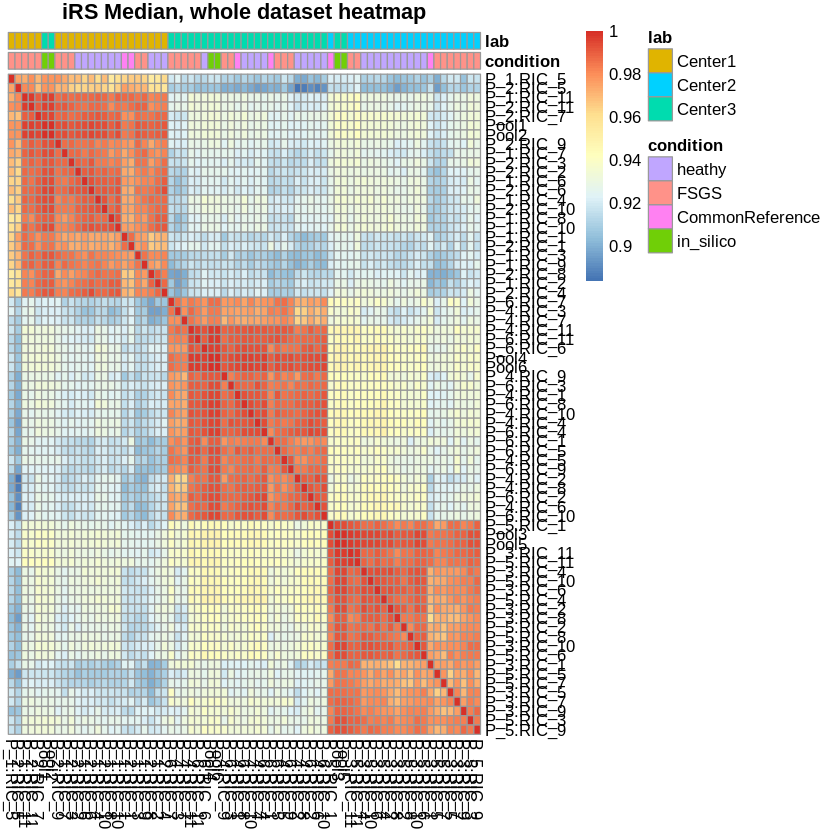

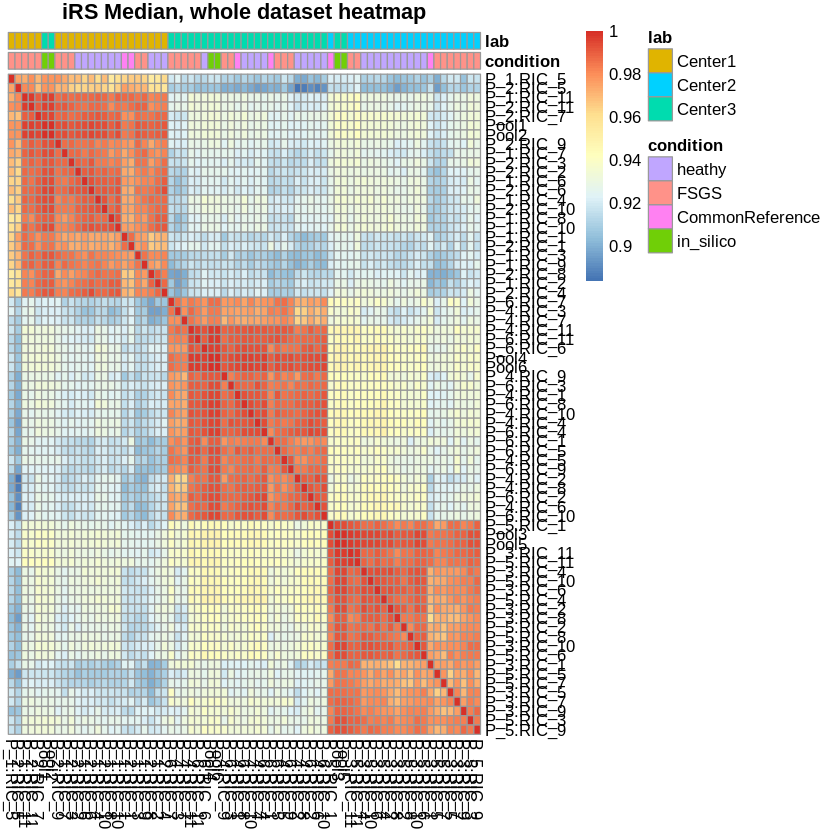



Dataset:  01_smaller_lib_downsampled_PG_MajorPG 
	Number of proteins:  628 
	Number of samples:  36 
Filtering out features that have NAs in all columns
	Before filtering: 628 36 
	After filtering: 621 36 
Filtering by condition - two not-NA per condition
	Before filtering: 628 36 
	After filtering: 554 36 
Rows after filtering 1 count: 531 
Rows after all filters: 531 
Filtering by lab  -  2  not-NA per  lab 
	Before filtering: 531 36 
	After filtering: 350 36 
Filtering by Pool  -  1  not-NA per  Pool 
	Before filtering: 350 36 
	After filtering: 323 36 
IRS normalization for center:  Center1 
Shape of intensities for pool  Pool1 : 323 6 
Shape of intensities for pool  Pool2 : 323 6 
IRS normalization for center:  Center2 
Shape of intensities for pool  Pool3 : 323 6 
Shape of intensities for pool  Pool5 : 323 6 
IRS normalization for center:  Center3 
Shape of intensities for pool  Pool4 : 323 6 
Shape of intensities for pool  Pool6 : 323 6 


No id variables; using all as measure variables



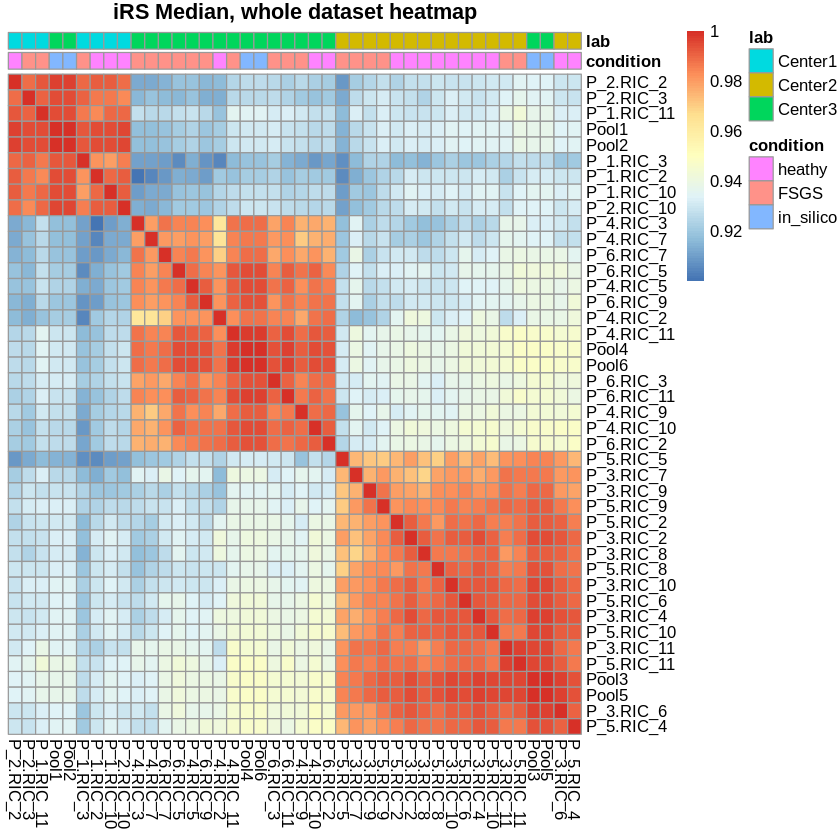

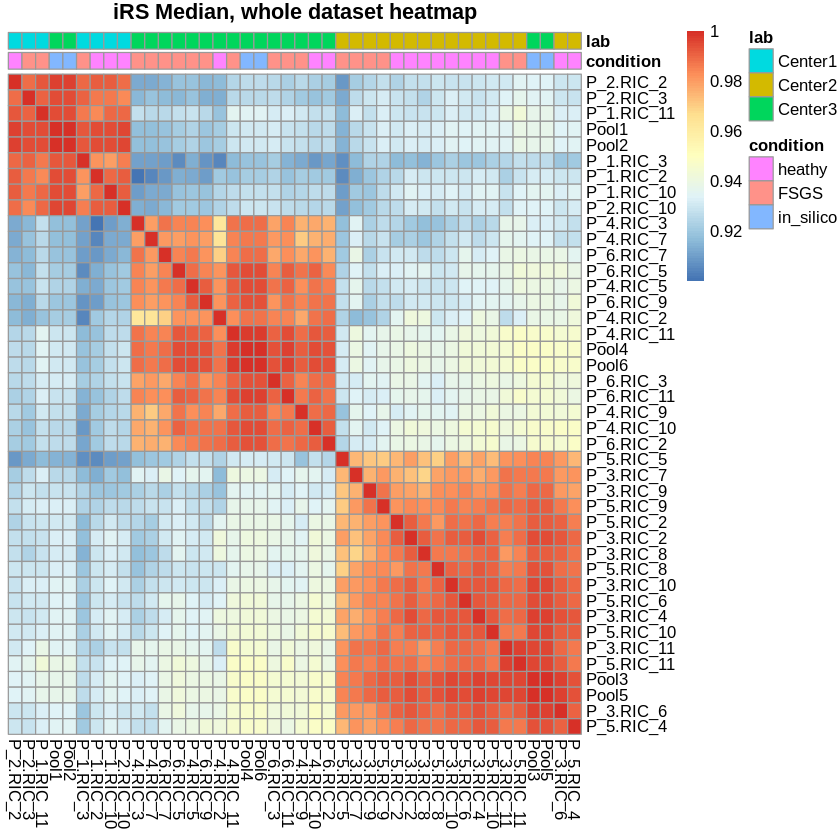

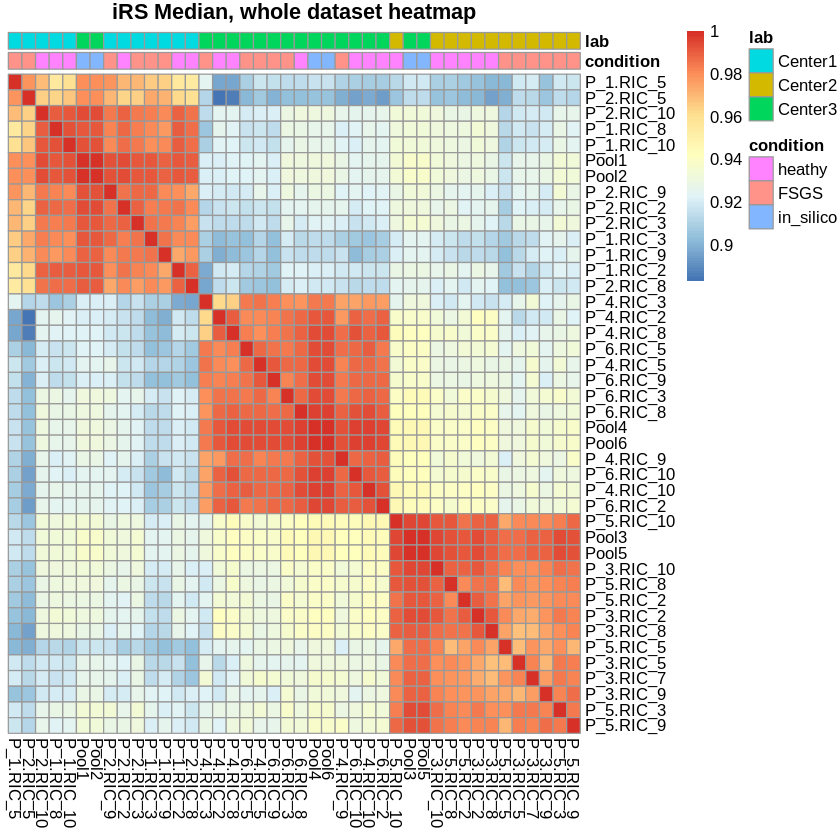

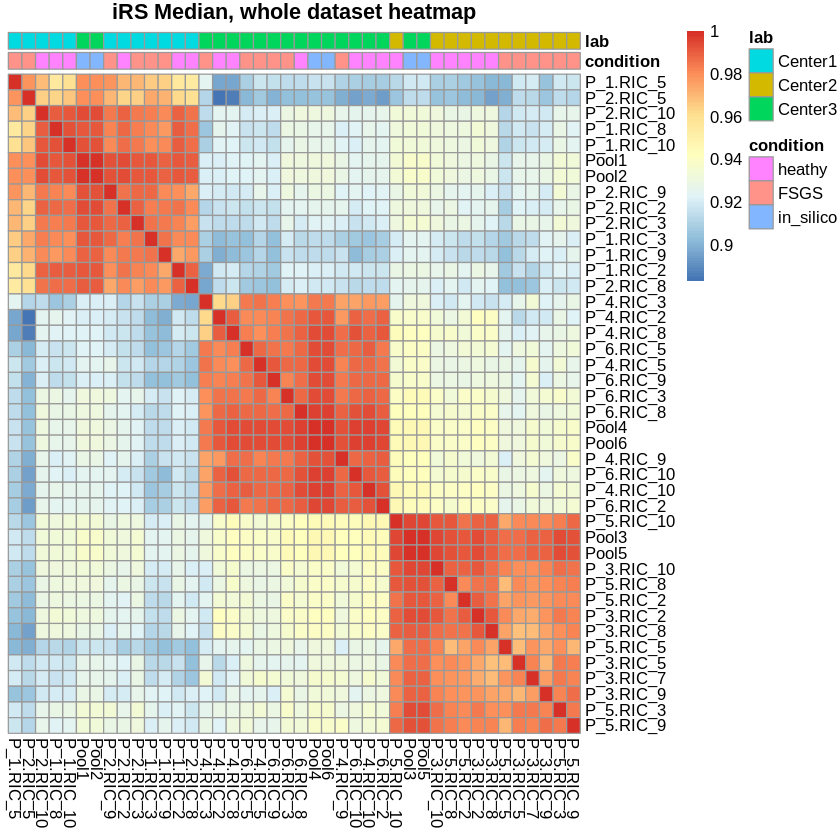

In [8]:
datasets_list = c('01_smaller_lib_balanced_PG_MajorPG', '01_smaller_lib_imbalanced_PG_MajorPG', "01_smaller_lib_downsampled_PG_MajorPG")
labs_list = c('Center1', 'Center2', 'Center3')

for (dataset in datasets_list){
  path_to_reports = paste0('/home/yuliya/repos/cosybio/FedProt/data/TMT_data/', dataset, "/")
  output_path = paste0('/home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/', dataset, '/results/')
  if(!dir.exists(output_path)){
    dir.create(output_path)
  }

  central_intensities = NULL
  central_counts = NULL

  central_batch_info = read_tsv(paste0(path_to_reports, 'metadata.tsv'), show_col_types = FALSE)
  central_batch_info <- central_batch_info  %>%
    mutate(Group = ifelse(Group == "Common Reference", "CommonReference", Group)) %>%
    mutate(
        file = Quantitative.column.name,
        lab = as.factor(Center),
        condition = factor(Group, levels = c('heathy', 'FSGS', "CommonReference"))
    )

  for (name in labs_list) {
    intensities = read_tsv(paste0(path_to_reports, name, '/pg_intensities.tsv'), show_col_types = FALSE)
    counts = read_tsv(paste0(path_to_reports, name, '/pg_counts.tsv'), show_col_types = FALSE)

    if(is.null(central_intensities)){
      central_intensities = intensities
      central_counts = counts
    } else {
      central_intensities = full_join(central_intensities, intensities, by = 'Majority.protein.IDs')
      central_counts = full_join(central_counts, counts, by = 'Majority.protein.IDs')
    }
  }

  cat('\n\nDataset: ', dataset, "\n")
  cat('\tNumber of proteins: ', nrow(central_intensities), '\n')
  cat('\tNumber of samples: ', ncol(central_intensities)-1, '\n')

  # transform and order
  central_intensities <- central_intensities %>% column_to_rownames('Majority.protein.IDs')
  central_counts <- central_counts %>% column_to_rownames('Majority.protein.IDs')

  central_intensities <- central_intensities[, central_batch_info$file]

  ########################################################################################
  # filter by condition
  intensities <- filter_na_proteins(central_intensities, central_batch_info, "file")
  central_intensities <- filter_by_condition(central_intensities, central_batch_info, 
        'file', c('heathy', 'FSGS'), 'condition') 

  ######################################################### 
  # select minimal count across column for each protein (with na.rm = TRUE)
  central_counts$count <- apply(central_counts, 1, min, na.rm = TRUE)
  central_counts <- central_counts %>% select(count)
  # Filter - remove proteins with 1 count 
  central_intensities <- central_intensities[rownames(central_intensities) %in% rownames(filter(central_counts, count > 1)), ]
  cat("Rows after filtering 1 count:", nrow(central_intensities), "\n")


  if (dataset == '01_smaller_lib_balanced_PG_MajorPG'){
    for_file_i <-central_intensities
    for_file_c <- central_counts
  }
  
  cat("Rows after all filters:", nrow(central_intensities), "\n")
  analyzed_proteins[[dataset]] <- rownames(central_intensities)
  
  filter_list_META[[dataset]][['Central']] <- rownames(central_intensities)

  central_intensities <- filter_per_center(central_intensities, central_batch_info, "file",
    unique(central_batch_info$lab), 'lab')

  # filter by pool - min 1 per pool
  central_intensities <- filter_per_center(central_intensities, central_batch_info, "file",
    unique(central_batch_info$Pool), 'Pool', min_number=1)

  ########################################################################################
  # NORMALIZATION for plots
  # median normalization
  central_intensities_plot <- medianNorm(central_intensities) %>% as.data.frame()
  central_batch_info_plot <- central_batch_info

  corrected_intensities <- NULL
  updates_metadata <- NULL

  # irs with in silico reference
  for(center in labs_list){
    cat("IRS normalization for center: ", center, "\n")
    center_intensities <- central_intensities_plot[, central_batch_info_plot$lab == center]
    center_batch_info <- central_batch_info_plot[central_batch_info_plot$lab == center, ]

    irs_res <- irsNorm_in_silico_single_center(
      center_intensities, center_batch_info,
      pool_col = "Pool",
      column_name = "file",
      center = name,
      aggregation_method = "average"
    )

    # add to the central data
    if(is.null(corrected_intensities)){
      corrected_intensities = irs_res$corrected_data
      updates_metadata = irs_res$metadata
    } else {
      corrected_intensities = cbind(corrected_intensities, irs_res$corrected_data)
      updates_metadata = rbind(updates_metadata, irs_res$metadata)
    }
  }
  
  central_batch_info_plot <- updates_metadata %>% as.data.frame() %>%
    mutate(
        file = as.character(file),
        lab = as.factor(as.character(lab)),
        Pool = as.factor(as.character(Pool)),
        condition = factor(as.character(condition), levels = c('heathy', 'FSGS', "CommonReference", "in_silico"))
      )

  central_intensities_plot <- corrected_intensities %>% as.data.frame()
  central_intensities_plot <- central_intensities_plot[, central_batch_info_plot$file]
  rownames(central_intensities_plot) <- central_intensities_plot$file

  # plot results
  create_plots(central_intensities_plot, central_batch_info_plot, "iRS Median, whole dataset",
    "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/01_smaller_lib_balanced_PG_MajorPG/IRS_median",
    shape_col = "lab", width = 20)
}


In [9]:
dim(for_file_i)

[1] 532  65

In [10]:
write.table(for_file_i, file = "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/01_smaller_lib_balanced_PG_MajorPG/pg_intensities.tsv", sep = "\t", quote = FALSE, row.names = F)
write.table(for_file_c, file = "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/01_smaller_lib_balanced_PG_MajorPG/pg_counts.tsv", sep = "\t", quote = FALSE, row.names = F)



In [11]:
datasets_list = c('01_smaller_lib_balanced_PG_MajorPG', '01_smaller_lib_imbalanced_PG_MajorPG', "01_smaller_lib_downsampled_PG_MajorPG")
labs_list = c('Center1', 'Center2', 'Center3')

for (dataset in datasets_list){
  path_to_reports = paste0('/home/yuliya/repos/cosybio/FedProt/data/TMT_data/', dataset, "/")
  output_path = paste0('/home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/', dataset, '/results/')
  if(!dir.exists(output_path)){
    dir.create(output_path)
  }

  central_intensities = NULL
  central_counts = NULL

  central_batch_info = read_tsv(paste0(path_to_reports, 'metadata.tsv'), show_col_types = FALSE)
  central_batch_info <- central_batch_info[central_batch_info$Group != "Common Reference" & central_batch_info$Group != "in_silico", ]
  central_batch_info <- central_batch_info  %>%
    filter(Group != "Common Reference") %>%
    mutate(
        file = Quantitative.column.name,
        lab = as.factor(Center),
        condition = factor(Group, levels = c('heathy', 'FSGS')),
        Pool = as.factor(Pool)
    )
  cat("Number of samples: ", nrow(central_batch_info), "\n")

  for (name in labs_list) {
    intensities = read_tsv(paste0(path_to_reports, name, '/pg_intensities.tsv'), show_col_types = FALSE)
    counts = read_tsv(paste0(path_to_reports, name, '/pg_counts.tsv'), show_col_types = FALSE)

    if(is.null(central_intensities)){
      central_intensities = intensities
      central_counts = counts
    } else {
      central_intensities = full_join(central_intensities, intensities, by = 'Majority.protein.IDs')
      central_counts = full_join(central_counts, counts, by = 'Majority.protein.IDs')
    }
  }

  cat('\n\nDataset: ', dataset, "\n")
  cat('\tNumber of proteins: ', nrow(central_intensities), '\n')
  cat('\tNumber of samples: ', ncol(central_intensities)-1, '\n')

  # transform and order
  central_intensities <- central_intensities %>% column_to_rownames('Majority.protein.IDs')
  central_counts <- central_counts %>% column_to_rownames('Majority.protein.IDs')

  central_intensities <- central_intensities[, central_batch_info$file]

  ######################################################### 
  # select minimal count across column for each protein (with na.rm = TRUE)
  central_counts$count <- apply(central_counts, 1, min, na.rm = TRUE)
  central_counts <- central_counts %>% select(count)
  # Filter - remove proteins with 1 count 
  central_intensities <- central_intensities[rownames(central_intensities) %in% rownames(filter(central_counts, count > 1)), ]
  cat("Rows after filtering 1 count:", nrow(central_intensities), "\n")

  ########################################################################################
  # filter by condition
  central_intensities <- filter_na_proteins(central_intensities, central_batch_info, "file")
  central_intensities <- filter_by_condition(central_intensities, central_batch_info, 
        'file', c('heathy', 'FSGS'), 'condition') 

  filter_list_META[[dataset]][['Central']] <- rownames(central_intensities)

  central_intensities <- filter_per_center(central_intensities, central_batch_info, "file",
    unique(central_batch_info$lab), 'lab')

  # filter by pool - min 1 per pool
  central_intensities <- filter_per_center(central_intensities, central_batch_info, "file",
    unique(central_batch_info$Pool), 'Pool', min_number=1)

  cat("Rows after all filters:", nrow(central_intensities), "\n")

  ###############################################################################################
  # DE analysis
  central_intensities <- central_intensities[, central_batch_info$file]

  # median normalization
  central_intensities <- medianNorm(central_intensities) %>% as.data.frame()

  # IRS normalization
  corrected_intensities <- NULL

  for(center in labs_list){
    cat("IRS normalization for center: ", center, "\n")
    center_intensities <- central_intensities[, central_batch_info$lab == center]
    center_batch_info <- central_batch_info[central_batch_info$lab == center, ]
    cat("Shape of the data: ", dim(center_intensities), "\n")

    irs_res <- irsNorm_in_silico_single_center(
      center_intensities, center_batch_info,
      pool_col = "Pool",
      column_name = "file",
      center = name,
      aggregation_method = "average",
      add_refs = FALSE
    )
    # add to the central data
    if(is.null(corrected_intensities)){
      corrected_intensities = irs_res$corrected_data
    } else {
      corrected_intensities = cbind(corrected_intensities, irs_res$corrected_data)
    }
  }

  central_intensities <- corrected_intensities[, central_batch_info$file]
  central_intensities <- log2(central_intensities + 1)
  cat("Number of samples for analysis: ", ncol(central_intensities), "\n")
  cat("Number of proteins for analysis: ", nrow(central_intensities), "\n")

  central_batch_info <- central_batch_info %>% mutate(
    condition = factor(condition, levels = c('heathy', 'FSGS')),
    Pool = as.factor(Pool)
  )

  # run DE analysis
  design <- make_design(central_batch_info, 'condition', 'Pool')
  cat("Design shape: ", dim(design), "\n")
  contrasts <- makeContrasts(heathy-FSGS, levels = colnames(design))
  de_results <- run_DE(central_intensities, central_counts, design, contrasts)
  de_results <- de_results %>% rownames_to_column('Protein')
  write.table(de_results, file = paste0(output_path, "/central_res.tsv"), sep = "\t", quote = FALSE, row.names = FALSE)

  cat("Number of DE proteins: (sca.adj.pval<0.05 & log2FC>0.25): ", sum((de_results$sca.adj.pval < 0.05 & abs(de_results$logFC) > 0.25)), "\n")

  # plot volcano plot
  plot_result <- volcano_plot(
    de_results, paste(dataset, "central", ", healthy/FSGS"),
    pval_threshold = 0.05, logfc_threshold = 0.25,
    show_names = FALSE
  )
  ggsave(file = paste0(output_path, '/central_volcano_plot.svg'), plot = plot_result, width = 8, height = 5)

  rownames(de_results) <- de_results$Protein
  plot_result <- volcano_plot(
    de_results, paste(dataset, "central", ", healthy/FSGS"),
    pval_threshold = 0.05, logfc_threshold = 0.25,
    show_names = TRUE
  )
  ggsave(file = paste0(output_path, '/central_volcano_plot_names.svg'), plot = plot_result, width = 8, height = 5)
}


Number of samples:  59 


Dataset:  01_smaller_lib_balanced_PG_MajorPG 
	Number of proteins:  628 
	Number of samples:  65 
Rows after filtering 1 count: 583 
Filtering out features that have NAs in all columns
	Before filtering: 583 59 
	After filtering: 580 59 
Filtering by condition - two not-NA per condition
	Before filtering: 580 59 
	After filtering: 532 59 
Filtering by lab  -  2  not-NA per  lab 
	Before filtering: 532 59 
	After filtering: 350 59 
Filtering by Pool  -  1  not-NA per  Pool 
	Before filtering: 350 59 
	After filtering: 323 59 
Rows after all filters: 323 
IRS normalization for center:  Center1 
Shape of the data:  323 20 
Shape of intensities for pool  Pool1 : 323 10 
Shape of intensities for pool  Pool2 : 323 10 
IRS normalization for center:  Center2 
Shape of the data:  323 19 
Shape of intensities for pool  Pool3 : 323 9 
Shape of intensities for pool  Pool5 : 323 10 
IRS normalization for center:  Center3 
Shape of the data:  323 20 
Shape of intensities fo

In [12]:
analysed_proteins <- list()

for(dataset in datasets_list){
    analysed_proteins[[dataset]] <- list()
    analysed_proteins[[dataset]]$central <- filter_list_META[[dataset]][['Central']]
    analysed_proteins[[dataset]]$meta <- meta_filter[[dataset]]
}

# write to json
write_json(analysed_proteins, "/home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/analysed_proteins.json")

# run metaanalyses

In [13]:
# cd /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/Meta_DE/01_smaller_lib_balanced_PG_MajorPG/

# Rscript /home/yuliya/repos/cosybio/FedProt/evaluation_utils/meta_code/run_MetaDE.R /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/Meta_DE/01_smaller_lib_balanced_PG_MajorPG/ Center1 Center2 Center3
# Rscript /home/yuliya/repos/cosybio/FedProt/evaluation_utils/meta_code/run_MetaVolcanoR.R /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/Meta_DE/01_smaller_lib_balanced_PG_MajorPG/ Center1 Center2 Center3
# Rscript /home/yuliya/repos/cosybio/FedProt/evaluation_utils/meta_code/run_RankProd.R /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/Meta_DE/01_smaller_lib_balanced_PG_MajorPG/ Center1 Center2 Center3

# cp /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/Meta_DE/01_smaller_lib_balanced_PG_MajorPG/MA_* /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/01_smaller_lib_balanced_PG_MajorPG/results/

In [14]:
# cd /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/Meta_DE/01_smaller_lib_imbalanced_PG_MajorPG/

# Rscript /home/yuliya/repos/cosybio/FedProt/evaluation_utils/meta_code/run_MetaDE.R /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/Meta_DE/01_smaller_lib_imbalanced_PG_MajorPG/ Center1 Center2 Center3
# Rscript /home/yuliya/repos/cosybio/FedProt/evaluation_utils/meta_code/run_MetaVolcanoR.R /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/Meta_DE/01_smaller_lib_imbalanced_PG_MajorPG/ Center1 Center2 Center3
# Rscript /home/yuliya/repos/cosybio/FedProt/evaluation_utils/meta_code/run_RankProd.R /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/Meta_DE/01_smaller_lib_imbalanced_PG_MajorPG/ Center1 Center2 Center3

# cp /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/Meta_DE/01_smaller_lib_imbalanced_PG_MajorPG/MA_* /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/01_smaller_lib_imbalanced_PG_MajorPG/results/

In [15]:
# cd /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/Meta_DE/01_smaller_lib_downsampled_PG_MajorPG/

# Rscript /home/yuliya/repos/cosybio/FedProt/evaluation_utils/meta_code/run_MetaDE.R /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/Meta_DE/01_smaller_lib_downsampled_PG_MajorPG/ Center1 Center2 Center3
# Rscript /home/yuliya/repos/cosybio/FedProt/evaluation_utils/meta_code/run_MetaVolcanoR.R /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/Meta_DE/01_smaller_lib_downsampled_PG_MajorPG/ Center1 Center2 Center3
# Rscript /home/yuliya/repos/cosybio/FedProt/evaluation_utils/meta_code/run_RankProd.R /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/Meta_DE/01_smaller_lib_downsampled_PG_MajorPG/ Center1 Center2 Center3

# cp /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/Meta_DE/01_smaller_lib_downsampled_PG_MajorPG/MA_* /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/01_smaller_lib_downsampled_PG_MajorPG/results/